In [49]:
#mathhmatical modules =====================================
import numpy as np
import math
#==========================================================
#scikit-learning modules ==================================
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt,image
#==========================================================
#scikit-image =============================================
import skimage.io as io
from skimage.exposure import histogram
from skimage.color import rgb2gray,rgb2hsv,label2rgb
from skimage.util import random_noise
from skimage.feature import canny
from skimage.measure import label
from skimage.filters import gaussian,thresholding,threshold_otsu
import skimage.restoration as resto
from skimage import img_as_float,img_as_ubyte
import skimage.segmentation as seg
#==========================================================
#scipy lib for transformative operations ==================
from scipy.signal import convolve2d
from scipy import fftpack,ndimage
#==========================================================
#Comprehensive Image libraries ============================
import cv2 
# import cvlib as cv
#==========================================================
#quality assessment modules ===============================
import imquality.brisque as brisque
#==========================================================
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
#==========================================================
import commonfunctions #======important functions===
#==========================================================
# import rembg  as rm #background removal libraries =========
import PIL as PL #image control ===========================
#==========================================================
# import cvzone as zone #====================================
from cvzone.SelfiSegmentationModule import SelfiSegmentation
import os #================================================

In [50]:
def extract_objects_contours(img):
    objects = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edges = cv2.Canny(gray,100,200)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    i=0
    cnts,heir= cv2.findContours(closed.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        cv2.drawContours(img, [approx], -1, (0, 255, 0), 2)
        x,y,w,h =cv2.boundingRect(c)
        objects.append((x,y,w,h))
        i=i+1
        newImage=img[y:y+h,x:x+w]
        return newImage,objects

In [51]:
def applySift(train_image , test_image):
    train_image = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1,desc1 = sift.detectAndCompute(train_image,None)
    kp2,desc2 = sift.detectAndCompute(test_image,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1,desc2,k=2)
    
    #apply test 
    good = [] 

    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    img3 = cv2.drawMatchesKnn(train_image,kp1,test_image,kp2,good[:50],None,flags=2)
    commonfunctions.show_images([img3])
    return

In [52]:
def find_matching_boxes(image, template, detector_method, params):
    """
    template: Lost object image
    image: box image
    detector_method: SIFT or ORB
    params: dictionary of parameters (max_matching_objects, SIFT_distance_threshold, best_matches_points)
    """
    # Parameters and their default values
    MAX_MATCHING_OBJECTS = params.get('max_matching_objects', 10)
    SIFT_DISTANCE_THRESHOLD = params.get('SIFT_distance_threshold', 0.7)
    BEST_MATCHES_POINTS = params.get('best_matches_points', 50)

    # Initialize the detector and matcher
    if detector_method == "SIFT":
        detector = cv2.SIFT_create()
        bf = cv2.BFMatcher()
    elif detector_method == "ORB":
        detector = cv2.ORB_create(fastThreshold=5, edgeThreshold=10)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    else:
        raise ValueError("Unsupported detector method")

    # Find keypoints and descriptors for the template
    keypoints2, descriptors2 = detector.detectAndCompute(template, None) # lost object image (keypoints and feature vectors)

    matched_boxes = []
    matching_img = image.copy() # box image

    for i in range(MAX_MATCHING_OBJECTS):
        # Match descriptors
        keypoints1, descriptors1 = detector.detectAndCompute(matching_img, None) # box image (keypoints and feature vectors)

        if detector_method == "SIFT":
            # Matching strategy for SIFT
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)
            good_matches = [m for m, n in matches if m.distance < SIFT_DISTANCE_THRESHOLD * n.distance]
            good_matches = sorted(good_matches, key=lambda x: x.distance)[:BEST_MATCHES_POINTS]

        elif detector_method == "ORB":
            # Matching strategy for ORB
            matches = bf.match(descriptors1, descriptors2)
            matches = sorted(matches, key=lambda x: x.distance)
            good_matches = matches[:BEST_MATCHES_POINTS]
        
        else:
            raise ValueError("Unsupported detector method")

        # Extract location of good matches
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

        # Find homography for drawing the bounding box
        try:
            H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 2)
        except cv2.error:
            print("No more matching box")
            break

        # Transform the corners of the template to the matching points in the image
        h, w = template.shape[:2]
        corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, H)
        matched_boxes.append(transformed_corners)

        # You can uncomment the following lines to see the matching process
        # Draw the bounding box
        img1_with_box = matching_img.copy()
        matching_result = cv2.drawMatches(img1_with_box, keypoints1, template, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        cv2.polylines(matching_result, [np.int32(transformed_corners)], True, (255, 0, 0), 3, cv2.LINE_AA)
        plt.imshow(matching_result, cmap='gray')
        plt.show()

        # Create a mask and fill the matched area with near neighbors
        matching_img2 = cv2.cvtColor(matching_img, cv2.COLOR_BGR2GRAY) 
        mask = np.ones_like(matching_img2) * 255
        cv2.fillPoly(mask, [np.int32(transformed_corners)], 0)
        mask = cv2.bitwise_not(mask)
        matching_img = cv2.inpaint(matching_img, mask, 3, cv2.INPAINT_TELEA)

    return matched_boxes



In [53]:
def filter_based_on_image_quality(img):
    segmenentor = SelfiSegmentation()
    filtered_1 = img
    filtered_2 =img # segmenentor.removeBG(img,(255,255,255))
    # commonfunctions.show_images([filtered_1,filtered_2],["segmented image 1","segmented image 2"])
    starting_k = math.sqrt(2)
    starting_sigma = 1.5
    X = 0
    # previous = brisque.score(img)
    # final = None
    # while X < 5:
    #     test = gaussian(filtered_1, (filtered_1,starting_k**X) * starting_sigma)
    #     score = brisque.score(test)
    #     if score  < previous:
    #         final = test
    #         previous = score
    #     X += 1
        
def segment_extraction(img,objects):
    newimages = []
    for obj in objects:
        x,y,w,h = obj
        newimages.append(img[x-w//2:x+w//2,y-h//2:y+h//2])
    return newimages
             

In [54]:
pen_cluttered = cv2.imread('./reflective_object.jpg', 0) # Template
pen_cluttered = cv2.cvtColor(pen_cluttered, cv2.COLOR_BGR2RGB)
filter_based_on_image_quality(pen_cluttered)

In [55]:
pen_cluttered = cv2.imread('./marker.jpg') # Template
pen_cluttered = cv2.cvtColor(pen_cluttered, cv2.COLOR_BGR2RGB)
pen_cluttered = cv2.resize(pen_cluttered,(pen_cluttered.shape[1]//4,pen_cluttered.shape[0]//4))



#commonfunctions.show_images([pen_cluttered])

pen_copybook = cv2.imread('./eraser_marker.jpg') # Image 
pen_copybook = cv2.cvtColor(pen_copybook, cv2.COLOR_BGR2RGB)
pen_copybook = cv2.resize(pen_copybook,(pen_copybook.shape[1]//4,pen_copybook.shape[0]//4))

#commonfunctions.show_images([pen_copybook])



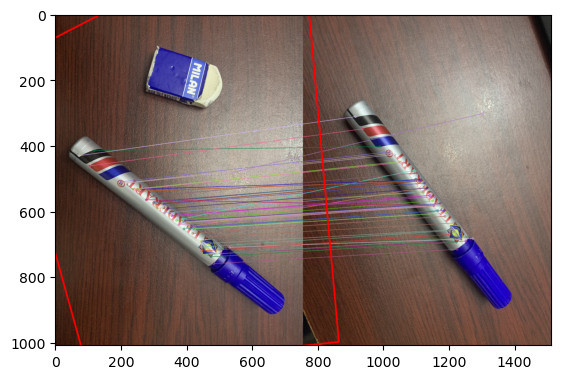

No more matching box


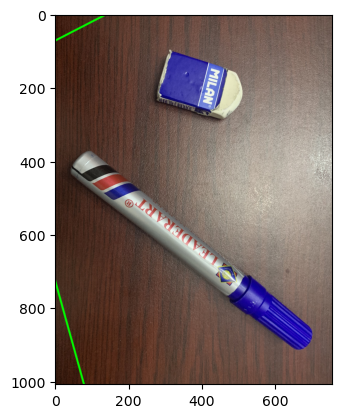

In [56]:
params = {
    'max_matching_objects': 5,
    'SIFT_distance_threshold': 0.7,
    'best_matches_points': 50
}

matched_boxes = find_matching_boxes(pen_copybook, pen_cluttered , "SIFT", params) 

# Draw the bounding boxes on the original image
for box in matched_boxes:
    cv2.polylines(pen_copybook, [np.int32(box)], True, (0, 255, 0), 3, cv2.LINE_AA)

plt.imshow(pen_copybook)
plt.show()

## Another Test

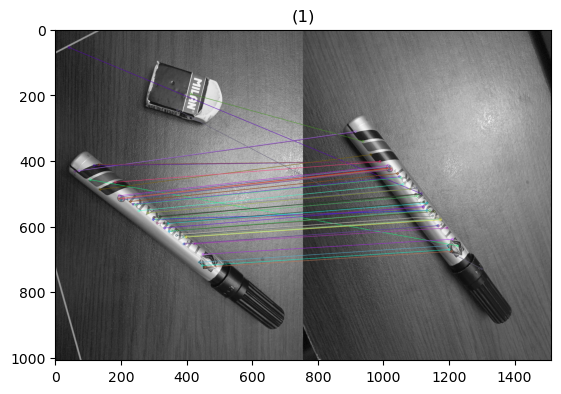

In [57]:
#applysift
applySift(pen_copybook,pen_cluttered)